## Conexión con la API

Previo al desarrollo de la aplicación, se debe pedir una autorización a la API de Twitter para poder acceder a los datos que se quieren analizar. Para ésto se debe crear una app desde la sección Developers de Twitter, donde se consiguen los tokens necesarios para la autorización de acceso, los cuales se agregan al archivo "twitter.ini", usado en el código a continuación.

In [1]:
import configparser  
import sys
from tweepy import API
from tweepy import OAuthHandler

def get_twitter_auth():
    config = configparser.ConfigParser()
    config.read("twitter.ini")
    
    try:
        consumer_key = config.get("TwitterKeys", "ConsumerKey")
        consumer_secret = config.get("TwitterKeys", "ConsumerSecret")
        access_token = config.get("TwitterKeys", "AccessToken")
        access_secret = config.get("TwitterKeys", "AccessTokenSecret")
    except:
        print("exception on %s!" % option)
        
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)
    return auth

def get_twitter_client():
    auth = get_twitter_auth()
    client = API(auth, wait_on_rate_limit = True)
    return client

auth = get_twitter_auth()
client = API(auth)
print("Se puede otorgar acceso a esta aplicación con el siguiente link: ")
print(auth.get_authorization_url(), "\n\n")

Se puede otorgar acceso a esta aplicación con el siguiente link: 
https://api.twitter.com/oauth/authorize?oauth_token=CQ4jnQAAAAAA_VLpAAABbJD23Qs 




## Obtención de datos del usuario

Importo todas las librerías necesarias para la obtención de datos y creo la carpeta "users", donde se almacenarán los usuarios analizados.

In [9]:
import os
import json
import time
import math
from tweepy import Cursor

MAX_FRIENDS = 1500

user_name = "delpotrojuan"
client = get_twitter_client()
dir_name = "users/{}".format(user_name)

max_pages = math.ceil(MAX_FRIENDS / 5000)

try:
    os.makedirs(dir_name, mode = 0o755, exist_ok = True)
except OSError:
    print("El directorio {} ya existe".format(dir_name))
except Exception as e:
    print("Error al crear el directorio {}".format(dir_name))
    print(e)
    sys.exit(1)
    
def paginate(items, n):
    for i in range(0, len(items), n):
        yield items[i:i+n]

#### Obtención de amigos

El código siguiente es el necesario para obtener los "friends" del usuario. De la misma manera se obtienen los seguidores, cambiando sólo el "folder_name" (friends por followers). Ésto último no se plasmó en este notebook por no ser necesario para el desarrollo del trabajo y por el hecho de tener básicamente el mismo código.

In [3]:
folder_name = "users/{}/friends.jsonl".format(user_name)

with open(folder_name, 'w') as f:
    for friends in Cursor(client.friends_ids, screen_name = user_name).pages(max_pages):
        
        for chunk in paginate(friends, 100):
            
            print("Descargando 100 friends de un total de ", len(friends))
            users = client.lookup_users(user_ids = chunk)
            
            for user in users:
                f.write(json.dumps(user._json)+"\n")
            
            if len(friends) == 5000:
                print("Espera de 60 segundos por el rate limit")
                time.sleep(60)
                
    print("Descarga finalizada")

Descargando 100 friends de un total de  23
Descarga finalizada


## Perfil de publicaciones del usuario

#### User timeline del usuario

Como paso inicial, descargo una lista de los primeros tweets del timeline del usuario. En este caso seran 16 páginas de 200 tweets cada una.

In [4]:
folder_name = "user_timeline_2019_{}.jsonl".format(user_name)
page_nro = 1

with open(folder_name, 'w') as f:
    
    for page in Cursor(client.user_timeline, screen_name = user_name, count = 200).pages(16):
        print("Descargando página {} con {} tweets".format(page_nro, len(page)))    
        page_nro += 1
        
        for status in page:
            f.write(json.dumps(status._json) + "\n")
    
    print ('Descarga finalizada')

Descargando página 1 con 200 tweets
Descargando página 2 con 200 tweets
Descargando página 3 con 200 tweets
Descargando página 4 con 200 tweets
Descargando página 5 con 106 tweets
Descarga finalizada


#### Análisis de los tweets descargados

Ahora se analizan los tweets del paso anterior con la librería "NLTK", para poder armar un perfil de intereses en base a ellos.

Primero importo las herramientas de análisis necesarias y defino el método "process" para tokenizar los tweets.

In [5]:
import string
from collections import Counter
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

def process(text, stopwords = []):
    tokenizer = TweetTokenizer(strip_handles = True, reduce_len = True)
    text = text.lower()
    tokens = tokenizer.tokenize(text)
    return [tok for tok in tokens if tok not in stopwords and not tok.isdigit()]

Obtengo la lista de "stopwords". La misma estará compuesta por las propias de los idiomas español e inglés (para darle amplitud al análisis) más las surgidas en las distintas ejecuciones.

In [6]:
tweet_tokenizer = TweetTokenizer()
punct = list(string.punctuation)
stopword_list = stopwords.words('spanish') + punct + ['rt', 'via', '...', '…', 'si', '!', '¡', 'jajaja', 'jajajaja', 'jajajajaja', '@', 'mas', 'voy', 'vos', 'sos', 'soy', '🇷', '"', ' ', '..', '¿', '?', 'ser', 'pessoas', 'seu', 'perfil', '“', 'q', '’', '”'] + stopwords.words('english')

Consigo los tokens a partir de los tweets y las stopwords; como dije anteriormente, esta lista se fue modificando en las distintas ejecuciones, al surgir palabras vacías para el análisis. Luego se imprimen las 20 más comunes.

In [7]:
folder_name = "user_timeline_2019_{}.jsonl".format(user_name)
tf = Counter()

with open(folder_name, 'r') as f:
    
    for line in f:
        tweet = json.loads(line)
        tokens = process(text = tweet.get('text', ''), stopwords = stopword_list)
        tf.update(tokens)
        
    for tag, count in tf.most_common(20):
        print("{}: {}".format(tag, count))

gracias: 146
feliz: 56
hola: 55
saludos: 54
gran: 53
entrenamiento: 49
great: 48
amigos: 47
día: 47
😀: 47
dejo: 46
️: 45
mensajes: 42
hoy: 41
🎾: 40
happy: 38
💪: 36
apoyo: 36
semana: 36
video: 36


Estos datos pueden visualizarse de manera gráfica, como se verá en la ejecución siguiente.

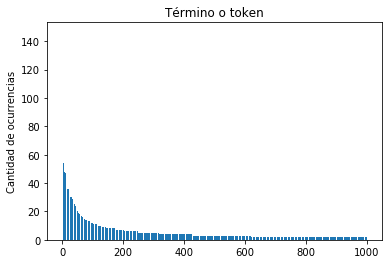

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

folder_name = "user_timeline_2019_{}.jsonl".format(user_name)
tf = Counter()
with open(folder_name, 'r') as f:
    
    for line in f:
        tweet = json.loads(line)
        tokens = process(text = tweet.get('text', ''), stopwords = stopword_list)
        tf.update(tokens)
        
    y = [count for tag, count in tf.most_common(1000)]
    x = range(1, len(y) + 1)
    plt.bar(x, y)
    plt.title("Término o token")
    plt.ylabel("Cantidad de ocurrencias")
    plt.show()

A partir de estos datos conseguidos se pueden analizar palabras clave para lograr encontrar un perfil del usuario. Por ejemplo, si entre las palabras clave se observan "fútbol", "partido", nombres de clubes, nombres de jugadores, etc., puedo decir que el usuario tiene un perfil orientado al deporte, específicamente al fútbol.

## Perfil de intereses 

Una de las formas de definir un perfil de intereses de un usuario es viendo qué cuentas sigue; un usuario que siga muchas cuentas relacionadas con deportes conducirá a la deducción de un interés relacionado a ello.

Como tengo que analizar todos los perfiles que sigue el usuario (los "friends"), lo mas conveniente es convertir el código de obtención de tweets y análisis de los mismos en funciones que facilitarán su uso en cada perfil seguido.

In [5]:
def get_tweets_usuario(user):
    folder_name = "user_timeline_2019_{}.jsonl".format(user)

    with open(folder_name, 'w') as f:
    
        for page in Cursor(client.user_timeline, screen_name = user, count = 100).pages(4):  #Un menor numero de tweets y paginas para reducir los tiempos de ejecucion
        
            for status in page:
                f.write(json.dumps(status._json) + "\n")

In [10]:
def analizar_usuario(user, tf):
    folder_name = "user_timeline_2019_{}.jsonl".format(user)

    with open(folder_name, 'r') as f:
    
        for line in f:
            tweet = json.loads(line)
            tokens = process(text = tweet.get('text', ''), stopwords = stopword_list)
            tf.update(tokens)

Una vez que tengo las funciones definidas, sólo me queda aplicarlas. En el código a continuación se consiguen los 20 tokens mas comunes presentes en todos los usuarios seguidos.

En un recorrido por todos los "friends" del usuario, se van obteniendo los tweets de cada uno y analizándolos a la vez. Este análisis se verá reflejado en el resultado final de la variable "tf", la cual almacena los tokens y la cantidad de ocurrencias de los mismos.

In [11]:
tf = Counter()
client = get_twitter_client()
folder_name = "users/{}/friends.jsonl".format(user_name)

with open(folder_name, 'r') as archivo:
    print ('Descargando')
    
    for user_name in archivo:
        try:
            profile = json.loads(user_name)
            user = profile['screen_name']
            get_tweets_usuario(user)
            analizar_usuario(user, tf)
        except:
            continue
        
    print ('Descarga finalizada')
    print ('')
        
for tag, count in tf.most_common(20):
    print("{}: {}".format(tag, count))

Descargando
Descarga finalizada

️: 1031
#wimbledon: 459
👏: 398
🏼: 385
💪: 354
🎾: 318
🏆: 308
🏻: 305
#rg19: 282
‍: 272
final: 252
🇦: 237
first: 236
one: 232
hoy: 225
day: 224
🔥: 218
❤: 218
🙌: 213
🙏: 198


Estos serian los tokens mas comunes obtenidos de las cuentas que sigue el usuario. A partir de ellos se obtiene un "perfil de intereses" que describirá la dinámica del usuario en relación a su propio perfil y los seguidos. 

Esta información también podría ser graficada, al igual que se hizo anteriormente para los tokens de un usuario particular.

## Clustering

Otra forma de determinar los intereses de un usuario es agrupando sus tweets por palabras claves. Este algoritmo se denomina clustering.

A continuación, el código donde se realiza el clustering del usuario analizado. El número de clusters será variable hasta encontrar el valor que mejor se ajuste al análisis.

In [73]:
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
user_name = "CFKArgentina"

connections_file = "user_timeline_2019_{}.jsonl".format(user_name)

with open(connections_file) as f:
    tweets = []
    
    for line in f:
        tweet = json.loads(line)
        tweets.append(tweet['text'])

    vectorizer = TfidfVectorizer(max_df = 0.8, min_df = 2, max_features = 200, stop_words = stopword_list,  ngram_range = (1, 3), 
                                 use_idf = True)
    X = vectorizer.fit_transform(tweets)
    print("Dimensiones de los datos: {}".format(X.shape))
    
    km = KMeans(n_clusters = 5)
    km.fit(X)
    clusters = defaultdict(list)
    
    for i, label in enumerate(km.labels_):
        clusters[label].append(tweets[i])
        
    for label, descriptions in clusters.items():
        print('---------------- CLUSTER {} ----------------'.format(label + 1))
        print ('')
        for desc in descriptions[:7]:
            print('-> ' + desc)
        print ('')
        print ('')

Dimensiones de los datos: (3199, 200)
---------------- CLUSTER 4 ----------------

-> Este agosto nos unimos para defender lo importante. https://t.co/DSEN6vBnw0
-> https://t.co/ODrwwGhjNQ
-> Por lo que le pido disculpas si se sintió ofendido, porque estuvo muy lejos mi intención de hacerle ningún tipo de… https://t.co/UGLM0kKEOp
-> Acabo de leer el twitt de Luis Novaresio en el que considera que le hice una imputación de cuasi torturador al refe… https://t.co/ormp0Yuf0G
-> Axel en una palabra: Gobernador. https://t.co/X1xzgfM1nc
-> Es necesario que todos hagamos el esfuerzo y tengamos la responsabilidad de organizarnos para que esto cambie. Esto… https://t.co/cbE04ClJgk
-> Humor y esperanza. Me encanta 😍 https://t.co/hNk62NmXni


---------------- CLUSTER 1 ----------------

-> Tenemos que convocar a todos los argentinos y a todas las argentinas a una unidad nacional para que la gente pueda… https://t.co/CtlzfF7QFo
-> “Ministerio de la Sinceridad - Prescindencia de la Nación” 

Alguien

## Geolocalización de tweets 

Existe una opción en los tweets de activar la ubicación desde la cual se efectuaron. Esta información de localización puede analizarse; a continuación se ve como crear un archivo (de extensión json) en el cual se guardaran las porciones de los tweets necesarias para el análisis, es decir, todo lo referido a la ubicación.

In [13]:
with open("tweets_traffic.jsonl", 'r', encoding = 'utf-8-sig') as f:
    geo_data = {
        "type": "FeatureCollection", "features": []
    }
    
    for line in f:
        tweet = json.loads(line)
        try:
            if tweet['geolocation']:
                geo_json_feature = {
                    "type": "Feature",
                    "geometry": {
                        "type": "Point",
                        "coordinates": tweet['geolocation']
                    },
                    "properties": {
                        "text": tweet['text'],
                        "created_at": tweet['creation_time']
                    }
                }
                geo_data['features'].append(geo_json_feature)
                
        except KeyError:
            continue
    
    with open("tweets_map_test.geo.json", 'w') as fout:
        fout.write(json.dumps(geo_data, indent = 4))

Este archivo json creado puede, a su vez, ser analizado. Y para este análisis existe la opción de visualizarlo en mapas. A continuación se creará un mapa con la informacion obtenida, en tres pasos.

Primero, marcamos individualmente cada uno de los tweets en el mapa.

In [14]:
import folium 

tweet_map = folium.Map(location = [-37.320480, -59.132904], zoom_start = 4)
geodata = json.load(open("tweets_map_test.geo.json", encoding = "utf-8-sig"))

for tweet in geodata['features']:
    marker = folium.Marker([tweet['geometry']['coordinates']['latitude'], tweet['geometry']['coordinates']['longitude']], 
                           popup = tweet['properties']['text'])
    marker.add_to(tweet_map)

tweet_map.save("mapa_de_tweets.html")

Luego agrupamos estos marcadores en clusters, los cuales incluirán más o menos datos según el zoom con el que se esté visualizando el mapa.

In [15]:
from folium.plugins import MarkerCluster

tweet_map = folium.Map(location = [-37.320480, -59.132904], zoom_start = 4)
marker_cluster = MarkerCluster().add_to(tweet_map)

for tweet in geodata['features']:
    marker = folium.Marker([tweet['geometry']['coordinates']['latitude'], tweet['geometry']['coordinates']['longitude']], 
                           popup = tweet['properties']['text'])
    marker.add_to(marker_cluster)

tweet_map.save("mapa_de_tweets.html")

Por último, agregamos a cada marcador el texto del tweet; con esta función se podrá ver cual es el tweet relacionado al marcador con sólo clickear sobre él.

In [16]:
tweet_map = folium.Map(location = [-37.320480, -59.132904], zoom_start = 4)
marker_cluster = MarkerCluster().add_to(tweet_map)

for tweet in geodata['features']:
    marker = folium.Marker([tweet['geometry']['coordinates']['latitude'], tweet['geometry']['coordinates']['longitude']], 
                           popup = tweet['properties']['text'])
    marker.add_to(marker_cluster)
    
tweet_map.save("mapa_de_tweets.html")